In [81]:
import os
import sys
import pandas as pd
import argparse 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob

In [117]:
def compute_t_tpm(df, full=False):
    counts_cols = [col for col in df.columns if 'sam' in col]
    df['counts'] = df[counts_cols].sum(axis=1)
    df.drop(counts_cols, axis=1, inplace=True)
    total_count = df.counts.sum()
    df['tpm'] = (df.counts*1000000)/total_count

    df = df[['transcript_ID', 'tpm']]

    if full:
        df.rename({'tpm': 'ab_tpm'}, axis=1, inplace=True)

    return df

def compute_g_tpm(df, full=False):
    counts_cols = [col for col in df.columns if 'sam' in col]
    df['counts'] = df[counts_cols].sum(axis=1)
    counts_cols = counts_cols+['transcript_ID', 'transcript_novelty']
    df.drop(counts_cols, axis=1, inplace=True)

    # gene groupby
    gb_cols = ['gene_ID', 'gene_novelty']
    df = df.groupby(gb_cols)['counts'].agg('sum').to_frame()
    df.reset_index(inplace=True)

    total_count = df.counts.sum()
    df['tpm'] = (df.counts*1000000)/total_count

    df = df[['gene_ID', 'tpm']]

    if full:
        df.rename({'tpm': 'ab_tpm'}, axis=1, inplace=True)

    return df

def filter(f_type, g_or_t, df):
    if g_or_t == 'gene':
        df = df.loc[df.gene_novelty == 'Known']
    elif g_or_t == 'transcript':
        if f_type == 'known':
            df = df.loc[df.transcript_novelty == 'Known']
        elif f_type == 'talon':
            df = df.loc[df.transcript_novelty.isin(['Known', 'NNC', 'NIC'])]
    return df

def get_read_num(elem):
    try:
        n = int(elem.split('_')[2])
    except:
        n = 8000000
    return n

In [118]:
def main(indir, prefix, f_type, maxfile):
    # get max reads
    with open(maxfile, 'r') as beep:
        for line in beep:
            max_reads = int(line.strip())
            max_reads = int(max_reads/2)

    # get each sam file in the input dir
    filt_files = []
    for file in glob.glob(indir+'*filtered.tsv'):
        filt_files.append(file)
    filt_files.sort(key=get_read_num)

    # get each sam file in the input dir
    ufilt_files = []
    for file in glob.glob(indir+'*abundance.tsv'):
        ufilt_files.append(file)
    ufilt_files.sort(key=get_read_num)

    # parse out the read numbers from each thing
    read_nums = [int(i.split('_')[2]) for i in filt_files[:-1]]
    read_nums.append('full')

    # load the full abundance files to compute ground-truth TPM vals
    g_df = pd.read_csv(ufilt_files[-1], sep='\t', usecols=[0,1,8,9,11,12])
    t_df = pd.read_csv(filt_files[-1], sep='\t', usecols=[0,1,8,9,11,12])

    # filter things according to whichever filter we've decided on
    g_df = filter(f_type, 'gene', g_df)
    t_df = filter(f_type, 'transcript', t_df)

    # compute tpms
    g_df = compute_g_tpm(g_df, full=True)
    t_df = compute_t_tpm(t_df, full=True)

    # plot de plot
    gene(g_df, ufilt_files, read_nums, f_type, max_reads, prefix)
    transcript(t_df, filt_files, read_nums, f_type, max_reads, prefix)

In [153]:
def gene(ab, ufilt_files, read_nums, f_type, max_reads, prefix):
    # bin transcripts by expression level. How many transcripts belong to each bin?
    # assign each transcript a bin based on its expression level as well
    # bins = [(0,1),(1,2),(2,5),(5,10),(10,50),(50,100),(100,500),(500,ab.ab_tpm.max())]
    bins = [5,10,50,100,500,ab.ab_tpm.max()+1]
    ab_tpm = ab.ab_tpm.values.tolist()
    ab_bins = np.digitize(ab_tpm, bins)
    ab['bin'] = ab_bins
    ab['bin_total'] = ab['bin'].map(ab['bin'].value_counts())

    # remove entries from bin 0
    ab = ab.loc[ab.bin != 0]

    # create a bin df to keep track of how many transcripts belong to each bin
    bin_df = ab[['bin', 'bin_total']].groupby(['bin', 'bin_total']).count()
    bin_df.reset_index(inplace=True)

    # loop through each interval and analyze subsampled data
    plot_data = pd.DataFrame(columns=['reads','bin','tpm_diff'])
    for fname,n in zip(ufilt_files, read_nums):

        # grab abundances, filter transcripts, and compute TPM
        sub_df = pd.read_csv(fname,sep='\t',usecols=[0,1,8,9,11,12])
        sub_df = filter(f_type, 'gene', sub_df)
        sub_df = compute_g_tpm(sub_df)

        # merge with full and determine if each gene is within 10%
        # of tpm val calculated with all reads
        sub_df = sub_df.merge(ab, how='right', on='gene_ID').fillna(0)
        sub_df['tpm_diff'] = sub_df.ab_tpm-sub_df.tpm
        sub_df['perc_tpm_diff'] = (sub_df.tpm_diff/sub_df.ab_tpm)*100

#         # set up some more metadata for plotting purposes
        if n == 'full':
            sub_df['reads'] = max_reads
        else:
            sub_df['reads'] = n
        plot_data = pd.concat([plot_data,sub_df[['reads','bin','tpm', 'ab_tpm','tpm_diff', 'perc_tpm_diff']]])
                              
#     # convert to human-readable TPM values
    plot_data = plot_data.merge(bin_df, on='bin')
    plot_data['TPM bin'] = plot_data.apply(lambda x:
        '{}-{} TPM n={}'.format(bins[x.bin-1],bins[x.bin],x.bin_total) if bins[x.bin-1] != 500 else '{}+ TPM n={}'.format(bins[x.bin-1], x.bin_total),
#         '{}-{} TPM'.format(bins[x.bin-1],bins[x.bin]) if bins[x.bin-1] != 500 else '{}+ TPM'.format(bins[x.bin-1]),                                   
                                           
        axis=1)
    
    sns.set(rc={'figure.figsize':(7,12)})
    sns.set_context('paper', font_scale=1.5)
    sns.set_style(style='white') 
    fig = plt.figure()

    # loop through the different tpm bins
    plot_df = plot_data
    print(plot_df.loc[plot_df.perc_tpm_diff == plot_df.perc_tpm_diff.min()])
    print(plot_df.loc[plot_df.perc_tpm_diff == plot_df.perc_tpm_diff.max()])
    
    bins = sorted(plot_df.bin.unique().tolist())
    for i,b in enumerate(bins):

        subplot_num = i+1
        fig.add_subplot(5,1,subplot_num)
        temp = plot_df.loc[plot_df.bin==b]

        ax = sns.boxplot(data=temp, x='reads', y='perc_tpm_diff', fliersize=1, saturation=1)
        ax.set(xlabel='', ylabel='', title=temp['TPM bin'].tolist()[0])
        ax.set(xlabel='', ylabel='', title=temp['TPM bin'].tolist()[0], ylim=(-150,110))
        if b == max(bins): 
            xticks = ['{:.2f}'.format(float(interval.get_text())/1000000) for interval in ax.get_xticklabels()]
            ax.set_xticklabels(xticks)
            ax.set(xlabel='Mapped reads (millions)')     
        else: 
            ax.set_xticklabels('')
#         if i == 0:
#             ax.set_title('Difference between final and subsampled TPM calculations per gene')
    fname = prefix+'gene_violin.pdf'
    plt.savefig(fname)

In [154]:
def transcript(ab, filt_files, read_nums, f_type, max_reads, prefix):

    # bin transcripts by expression level. How many transcripts belong to each bin?
    # assign each transcript a bin based on its expression level as well
    # bins = [(0,1),(1,2),(2,5),(5,10),(10,50),(50,100),(100,500),(500,ab.ab_tpm.max())]
    bins = [5,10,50,100,500,ab.ab_tpm.max()+1]
    ab_tpm = ab.ab_tpm.values.tolist()
    ab_bins = np.digitize(ab_tpm, bins)
    ab['bin'] = ab_bins
    ab['bin_total'] = ab['bin'].map(ab['bin'].value_counts())

    # remove entries from bin 0
    ab = ab.loc[ab.bin != 0]

    # create a bin df to keep track of how many transcripts belong to each bin
    bin_df = ab[['bin', 'bin_total']].groupby(['bin', 'bin_total']).count()
    bin_df.reset_index(inplace=True)

    # loop through each interval and analyze subsampled data
    plot_data = pd.DataFrame(columns=['reads','bin','tpm_diff'])
    for fname,n in zip(ufilt_files, read_nums):

        # grab abundances, filter transcripts, and compute TPM
        sub_df = pd.read_csv(fname,sep='\t',usecols=[0,1,8,9,11,12])
        sub_df = filter(f_type, 'gene', sub_df)
        sub_df = compute_t_tpm(sub_df)

        # merge with full 
        sub_df = sub_df.merge(ab, how='right', on='transcript_ID').fillna(0)
        sub_df['tpm_diff'] = sub_df.ab_tpm-sub_df.tpm
        sub_df['perc_tpm_diff'] = (sub_df.tpm_diff/sub_df.ab_tpm)*100

#         # set up some more metadata for plotting purposes
        if n == 'full':
            sub_df['reads'] = max_reads
        else:
            sub_df['reads'] = n
        plot_data = pd.concat([plot_data,sub_df[['reads','bin','tpm', 'ab_tpm','tpm_diff', 'perc_tpm_diff']]])
                              
#     # convert to human-readable TPM values
    plot_data = plot_data.merge(bin_df, on='bin')
    plot_data['TPM bin'] = plot_data.apply(lambda x:
        '{}-{} TPM n={}'.format(bins[x.bin-1],bins[x.bin],x.bin_total) if bins[x.bin-1] != 500 else '{}+ TPM n={}'.format(bins[x.bin-1], x.bin_total),
#         '{}-{} TPM'.format(bins[x.bin-1],bins[x.bin]) if bins[x.bin-1] != 500 else '{}+ TPM'.format(bins[x.bin-1]),                                   
        axis=1)
    
    sns.set(rc={'figure.figsize':(7,12)})
    sns.set_context('paper', font_scale=1.5)
    sns.set_style(style='white') 
    fig = plt.figure()

    # loop through the different tpm bins
    plot_df = plot_data
    bins = sorted(plot_df.bin.unique().tolist())
    for i,b in enumerate(bins):

        subplot_num = i+1
        fig.add_subplot(5,1,subplot_num)
        temp = plot_df.loc[plot_df.bin==b]

        ax = sns.boxplot(data=temp, x='reads', y='perc_tpm_diff', fliersize=1, saturation=1)
        ax.set(xlabel='', ylabel='', title=temp['TPM bin'].tolist()[0])
        ax.set(xlabel='', ylabel='', title=temp['TPM bin'].tolist()[0], ylim=(-150,110))
        if b == max(bins): 
            xticks = ['{:.2f}'.format(float(interval.get_text())/1000000) for interval in ax.get_xticklabels()]
            ax.set_xticklabels(xticks)
            ax.set(xlabel='Mapped reads (millions)')     
        else: 
            ax.set_xticklabels('')
#         if i == 0:
#             ax.set_title('Difference between final and subsampled TPM calculations per transcript')
    fname = prefix+'transcript_violin.pdf'
    plt.savefig(fname)
    fname = prefix+'transcript_violin.png'
    plt.savefig(fname)
    

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


      reads bin   tpm_diff        tpm    ab_tpm  perc_tpm_diff  bin_total  \
380  250000   1 -15.018119  21.490264  6.472144    -232.042405       1778   

             TPM bin  
380  5-10 TPM n=1778  
       reads bin  tpm_diff  tpm    ab_tpm  perc_tpm_diff  bin_total  \
16    250000   1  6.232435  0.0  6.232435          100.0       1778   
55    250000   1  6.711853  0.0  6.711853          100.0       1778   
93    250000   1  6.472144  0.0  6.472144          100.0       1778   
95    250000   1  5.513308  0.0  5.513308          100.0       1778   
128   250000   1  7.430981  0.0  7.430981          100.0       1778   
...      ...  ..       ...  ...       ...            ...        ...   
1771  250000   1  5.033890  0.0  5.033890          100.0       1778   
1776  250000   1  5.273599  0.0  5.273599          100.0       1778   
1920  500000   1  5.033890  0.0  5.033890          100.0       1778   
2686  500000   1  5.273599  0.0  5.273599          100.0       1778   
3554  500000   1  

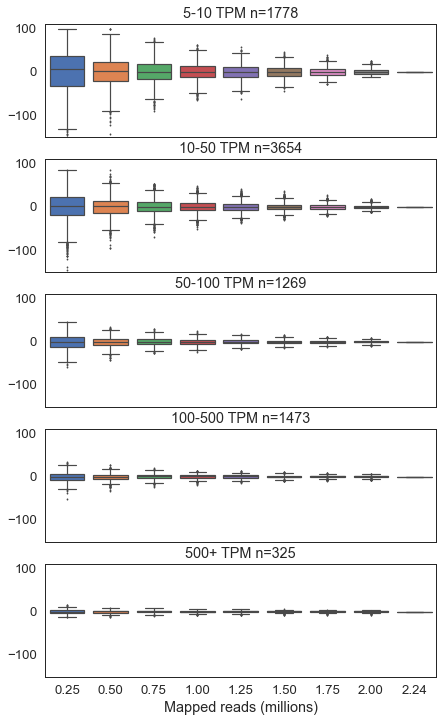

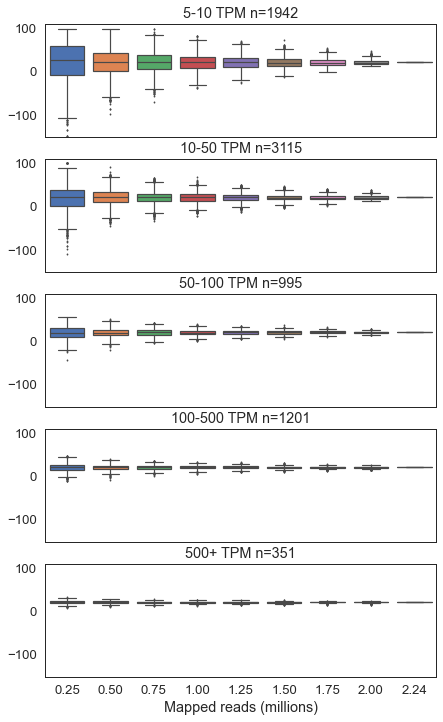

In [155]:
# PacBio known genes and transcripts

indir = 'pb_talon/'
prefix = 'figures/pacbio_known'
f_type = 'known'
maxfile = 'pb_talon/pb_talon_max_reads'

main(indir, prefix, f_type, maxfile)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


      reads bin   tpm_diff        tpm    ab_tpm  perc_tpm_diff  bin_total  \
287  250000   1 -19.379428  25.717519  6.338091    -305.761296       1887   

             TPM bin  
287  5-10 TPM n=1887  
        reads bin   tpm_diff  tpm     ab_tpm  perc_tpm_diff  bin_total  \
26     250000   1   5.985975  0.0   5.985975          100.0       1887   
35     250000   1   6.338091  0.0   6.338091          100.0       1887   
37     250000   1   8.450788  0.0   8.450788          100.0       1887   
78     250000   1   5.633858  0.0   5.633858          100.0       1887   
104    250000   1   5.281742  0.0   5.281742          100.0       1887   
...       ...  ..        ...  ...        ...            ...        ...   
14542  250000   2  10.563484  0.0  10.563484          100.0       4896   
14580  250000   2  10.211368  0.0  10.211368          100.0       4896   
15107  250000   2  13.380414  0.0  13.380414          100.0       4896   
16260  250000   2  13.380414  0.0  13.380414          100.0

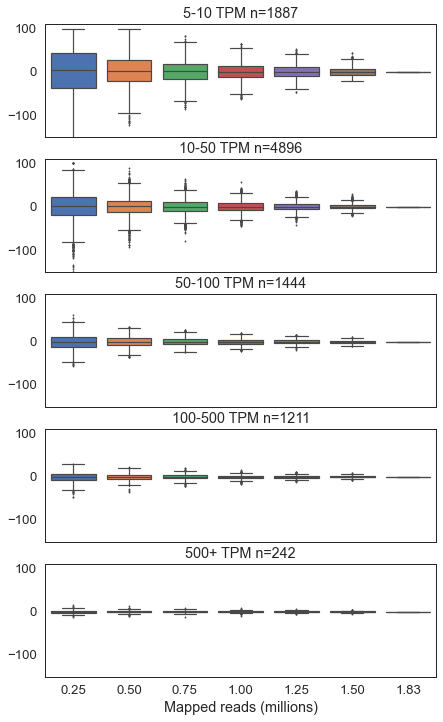

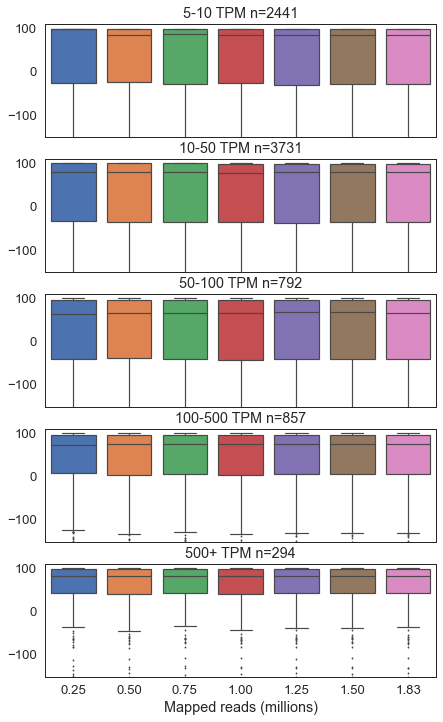

In [156]:
# ONT known genes and transcripts

indir = 'ont_talon/'
prefix = 'figures/ont_known'
f_type = 'known'
maxfile = 'ont_talon/ont_talon_max_reads'

main(indir, prefix, f_type, maxfile)